In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import csv
import random
import copy

from pyimagesearch.siamese_network import *
# from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
import os

### Paths

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/alvaro/Vehicle-Model-Recognition


It should be /home/user/Vehicle-Model-Recognition

In [3]:
def create_datetime_dirs(root_dir):
    date = datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    tb_logs_dir = os.path.join(root_dir, 'trainings', 'tensorboard_logs', date)
    save_models_dir = os.path.join(root_dir, 'trainings', 'models', date)
    os.makedirs(tb_logs_dir)
    os.makedirs(save_models_dir)
    return tb_logs_dir, save_models_dir

### Dataset parameters

In [4]:
total_classes = 10
elements_per_class = 75
training_split = 0.75
img_resolution = (224, 224)

### Training parameters

In [21]:
lr = 1e-4
epochs = 5000
batch_size = 128

### Load images

In [12]:
os.chdir(ROOT_DIR + '/dataset')

In [7]:
car_names = os.listdir('./')
car_names.sort()

In [8]:
labels = random.sample(car_names, k = total_classes)
labels.sort()
print(labels)

['BMW 1 Series Coupe 2012', 'BMW M3 Coupe 2012', 'Chevrolet Avalanche Crew Cab 2012', 'Dodge Durango SUV 2012', 'HUMMER H2 SUT Crew Cab 2009', 'Honda Accord Coupe 2012', 'Jeep Compass SUV 2012', 'Mercedes-Benz SL-Class Coupe 2009', 'Mitsubishi Lancer Sedan 2012', 'Nissan Leaf Hatchback 2012']


In [9]:
(trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox) = utils.load_dataset(ROOT_DIR, labels, elements_per_class, img_resolution=img_resolution,
                                                                                 crop=False, greyscale=False)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)
trainX.shape

(559, 224, 224, 3)

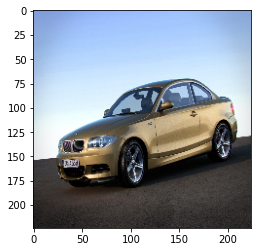

In [13]:
plt.imshow(trainX[0])

In [14]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(559, 224, 224, 3, 1)
(189, 224, 224, 3, 1)


In [15]:
norm_trainY = utils.normalize_labels(trainY)
norm_testY = utils.normalize_labels(testY)

In [16]:
oh_train = tf.one_hot(norm_trainY, len(np.unique(norm_trainY)))
oh_test = tf.one_hot(norm_testY, len(np.unique(norm_testY)))

In [17]:
vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None,input_shape=trainX.shape[1:4], classes=total_classes)

In [18]:
vgg16 = build_vgg16(trainX.shape[1:4])

In [19]:
vgg16.summary()

Model: "VGG16_confA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       

In [20]:
inputs = Input(shape=trainX.shape[1:4])
vgg16_outputs = vgg16(inputs)
outputs = Dense(len(np.unique(norm_trainY)), activation='relu')(vgg16_outputs)
model = Model(inputs, outputs)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
	metrics=["categorical_accuracy"])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_confA (Model)          (None, 128)               129290752 
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 129,292,042
Trainable params: 129,292,042
Non-trainable params: 0
_________________________________________________________________


In [24]:
class TensorboardCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        self.writer = tf.summary.create_file_writer(log_dir)
        self.writer.set_as_default()

    def on_epoch_end(self, epoch, logs=None):
        tf.summary.scalar('Train/Loss', logs['loss'], epoch)
        tf.summary.scalar('Train/Accuracy', logs['categorical_accuracy'], epoch)
        tf.summary.scalar('Val/Loss', logs['val_loss'], epoch)
        tf.summary.scalar('Val/Accuracy', logs['val_categorical_accuracy'], epoch)


In [ ]:
TB_LOG_DIR, SAVE_MODELS_DIR = create_datetime_dirs(ROOT_DIR)
tb_callback = TensorboardCallback(TB_LOG_DIR)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(SAVE_MODELS_DIR, monitor='val_categorical_accuracy', verbose=0, save_best_only=True,
                                                           save_weights_only=False, mode='auto', save_freq='epoch')

history = model.fit(
	trainX, oh_train,
	validation_data=(trainX, oh_train),
	batch_size=batch_size, 
	epochs=epochs,
    callbacks=[tb_callback, checkpoint_callback],
    verbose=1)

Epoch 1/5000
5/5 [==============================] - ETA: 0s - loss: 9.7094 - categorical_accuracy: 0.0823WARNING:tensorflow:From /home/alvaro/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/alvaro/Vehicle-Model-Recognition/trainings/models/24-02-2021 18:55:28/assets
5/5 [==============================] - 35s 7s/step - loss: 9.7094 - categorical_accuracy: 0.0823 - val_loss: 7.7309 - val_categorical_accuracy: 0.1002
Epoch 2/5000
5/5 [==============================] - 2s 347ms/step - loss: 7.6865 - categorical_accuracy: 0.1002 - val_loss: 7.6224 - val_categorical_accuracy: 0.1002
Epoch 3/5000
5/5 [==============================] - 2s 348ms/step - loss: 7.603